In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.layers import Input, Dense, LSTM, Embedding, \
Dropout, Activation, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.experimental.preprocessing import TextVectorization
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant


# !pip install -q -U keras-tuner
# import kerastuner as kt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from IPython.display import display

import re

import seaborn as sns
import matplotlib.pyplot as plt
from src import load_text, predict_grade, separate_sentences, prepare_text

import spacy
!python -m spacy download en_core_web_sm
import en_core_web_sm



pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# The Data
the data consists of anonymized essays and stories written by students in grades kindergarten through high school.  We've collected these from around the web.  Let's look at some statistics below.

## Alternative Grouping
We removed samples from grades K (0) and 1 because we suspect most of them were dictated and transcribed by teachers.  They don't seem to be representative of independent writing skills.

We also combined all high school grades to 12.  Previous iterations of the model did not do well distinguishing between high school level texts.  We changed them to 12 because later we want the model to use the average of sentences to predict the grade of a longer text.  The model will almost never predict 12 because an average will always bring it down.

lemmatize

In [2]:
sp = en_core_web_sm.load()
full_df = load_text()


col = 'Grammar'


In [3]:
df = full_df[full_df.Grade > 1]

X = df.Text
y = df.Grade

train = pd.DataFrame(columns = ['Grade','Text'])
test = pd.DataFrame(columns = ['Grade','Text'])

train['Text'], test['Text'], train['Grade'], test['Grade'] = train_test_split(X, y, random_state=111)
train = separate_sentences(train)
train = prepare_text(train, sp)

X_t, X_val, y_t, y_val = train_test_split(train.drop(columns = 'Grade'), train.Grade, random_state=111)

sns.barplot(x=df.Grade.unique(), y=df.Grade.value_counts())

You can see above that we have a large imbalance in grades represented.  It's tempting to cluster grades together, but we want a tool that predicts with some specificity.  Here's a lesson from my teaching years, however:  Most kids don't write sentences on their own in Kindergarten.  Looking over our texts for Kindergarten and first grade, these seem to be dictated and transcribed by an adult.  

In model development we also saw that high school texts are difficult to classify accurately as well.  For these reasons, we clump all high school and K-2nd grade together.  

fig, axes = plt.subplots(4,3, figsize = (13,13))
axes=axes.ravel()
grades = sorted(df.Grade.unique())
for i, grade in enumerate(grades):
    text = ' '.join([story for story in df.loc[df.Grade == grade, 'Text']])
    axes[i].imshow(WordCloud(width=800, height=400).generate(text))
    axes[i].set_title(f'Frequency of words in grade {int(grade)}')
    axes[i].axis('off')
fig.delaxes(axes[-1])
plt.tight_layout()
plt.savefig('word_clouds.png', dpi=200)
plt.show()
    

# FSM
How accurate would we be if we just predict all samples will be the median grade of the training set?  This can be our baseline model.

FSM = np.array([y_t.median()] * len(y_val))
FSM_MAE = np.sum(np.abs(y_val - FSM))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)

So, that means our model has to beat 2.5 MAE to have any predictive power.

# TF-IDF Vectorization

TF-IDF vectorization represents each word with a float representing its relative specificity to a given document.  The random forest model, however, is non-sequential.  It looks at each sentence as a collection of words.  Therefor the above power represents the opportunity to judge writing level purely by vocabulary used.

I'd like to have longer input sequences after vectorizing and padding than my longest sentence.  

Vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=None)
Vectorizer.adapt(X_t[col].to_numpy())
print(col)

X_t_tfidf = Vectorizer(X_t[col])
X_val_tfidf = Vectorizer(X_val[col])
    
X_t_tfidf

Lemmas

# Linear Regression

Let's see how far we can get with the simplest of linear predictive models based on the vocabulary in the text.

lr_reg = LinearRegression().fit(X_t_tfidf, y_t)
yhat = lr_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)
print('MAE for Linear Regression on TF-IDF vectors = ', mae)


The linear regression slightly beat predicting the median, but not by a lot.

# XGBoost

from xgboost import XGBRegressor
XGB_reg = XGBRegressor().fit(X_t_tfidf, y_t)
yhat = XGB_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)
print('MAE for XGBoost TF-IDF vectors = ', mae)

XGBoost did not seem to improve much.


## Shallow Model development opportunities:
My goal in this project is to explore deep learning NLP approaches, so I did not spend a lot of time tuning the traditional models.  I include them more as reference and justification for models that require greater computational resources.

Opportunities:

1. Hyperparameter tuning of traditional models

# Deep Models

I wonder if a model that explores the grammar and semantic relationships between words within the student writing samples might have greater insight into stages of writing development?  



# TextVectorization

We used TextVectorization as TF-IDF encoder above, but it can also be used as a Keras model layer.  I create a new TextVectorization object with appropriate sequence lengths for padding.  Each word will be encoded as an integer and sentences will be arrays of integers.

# Word Embedding

My first choice, in order to preserve some of the semantic relationships between the words I used word embeddings, rather than TF-IDF, to vectorize my texts.  This is a very different approach and, in fact, whereas in many other vectorization strategies each word is represented by a single number, word embeddings encode each word as a high dimensional vector array.  That means that a sentence becomes a 2D matrix.  

We don't encode the texts as such yet, but we do need to create a reference matrix to translate word encodings to their matching embedding vector.  Now Keras provides trainable embedding layers that learn along with the other layers of your model.  They contain huge numbers of weights depending on the size of your vocabulary and embedding length.

However, there are several libraries of pre-trained word embeddings that can be loaded.  I use the SpaCy NLP package to create a word embedding matrix as a 2D matrix.  The indices will be the keys and the matching row will be the embedding.  These integers match the encoding that the TextVectorization layer uses.

This matrix can then be loaded in as the weights of a Keras Embedding layer.  Remember to set `trainable=False`. The model will use the Embedding layer to cross-reference each word in the sentence.  These embeddings will suggest word relationships and will be read in order by the next layer, the Long-Short Term Memory layer.

Thanks to https://keras.io/examples/nlp/pretrained_word_embeddings/ and Kefei Mo https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633 for the below code to create the weights matrix:

In [4]:
# Establish sequence length.  Set here as the longest sentence in the training set.
X_train = train[col]
y_train = train.Grade
longest_sentence = X_train.str.len().max()

# Instantiate and fit the vectorizing layer.  
# We can use this as a transformer, a vocabulary, and a layer in our model.
Vectorizer = TextVectorization(output_sequence_length=longest_sentence, max_tokens=2000)
Vectorizer.adapt(X_train.to_numpy())
vocab = Vectorizer.get_vocabulary()


#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = len(sp('The').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab[1:]):
    embedding_matrix[i+1] = sp(word).vector

#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

# Hybrid Bi-directional
We are going to pull out all the guns here and use a bi-directional LSTM with that pre-trained SpaCy embedding layer.  We are going to throw that on top of a deep densely connected network with a global max pool layer between them.

The data comes in at the input layer and to the vectorizing layer which translates them into uniform length integer arrays.  Those arrays are are expanded into a 2D matrix in the Embedding layer.  The LSTM layer then reads the embeddings in the order they originally appeared in the text and makes choices about them.  This is a learned skill.  The bidirectional wrapper sends the text embedding both forward and backward through the layer and concatenates the output sequences together.  The GlobalMaxPooling1D layer reduces the dimensionality back down to pass to the densely connected layers.

The model then outputs a float which represents its guess at the grade level of the author of a text.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 1233)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1233, 96)          192000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 100)               58800     
_________________________________________________________________
dense_77 (Dense)             (None, 32)                3232      
_________________________________________________________________
dropout_70 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_71 (Dropout)         (None, 32)              

INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 2/60
63/63 [==============================] - 8s 134ms/step - loss: 2.6396 - val_loss: 2.4156

Epoch 00002: val_loss improved from 2.76476 to 2.41556, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 3/60
63/63 [==============================] - 9s 136ms/step - loss: 2.5416 - val_loss: 2.3584

Epoch 00003: val_loss improved from 2.41556 to 2.35844, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 4/60
63/63 [==============================] - 8s 134ms/step - loss: 2.4953 - val_loss: 2.4539

Epoch 00004: val_loss did not improve from 2.35844
Epoch 5/60
63/63 [==============================] - 8s 134ms/step - loss: 2.5402 - val_loss: 2.3412

Epoch 00005: val_loss improved from 2.35844 to 2.34118, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 6/60
63/63 [==============================] - 8s 135ms/step - loss: 2.4850 - val_loss: 2.3643

Epoch 00006: val_loss did not improve from 2.34118
Epoch 7/60
63/63 [==============================] - 8s 134ms/step - loss: 2.4724 - val_loss: 2.3186

Epoch 00007: val_loss improved from 2.34118 to 2.31856, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 8/60
63/63 [==============================] - 8s 134ms/step - loss: 2.4069 - val_loss: 2.2608

Epoch 00008: val_loss improved from 2.31856 to 2.26076, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 9/60
63/63 [==============================] - 9s 135ms/step - loss: 2.4072 - val_loss: 2.2249

Epoch 00009: val_loss improved from 2.26076 to 2.22487, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 10/60
63/63 [==============================] - 9s 135ms/step - loss: 2.3101 - val_loss: 2.1470

Epoch 00010: val_loss improved from 2.22487 to 2.14699, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 11/60
63/63 [==============================] - 8s 134ms/step - loss: 2.3056 - val_loss: 2.1355

Epoch 00011: val_loss improved from 2.14699 to 2.13547, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 12/60
63/63 [==============================] - 9s 137ms/step - loss: 2.2993 - val_loss: 2.2006

Epoch 00012: val_loss did not improve from 2.13547
Epoch 13/60
63/63 [==============================] - 9s 137ms/step - loss: 2.2838 - val_loss: 2.2563

Epoch 00013: val_loss did not improve from 2.13547
Epoch 14/60
63/63 [==============================] - 9s 136ms/step - loss: 2.2598 - val_loss: 2.1524

Epoch 00014: val_loss did not improve from 2.13547
Epoch 15/60
63/63 [==============================] - 9s 138ms/step - loss: 2.2066 - val_loss: 2.1328

Epoch 00015: val_loss improved from 2.13547 to 2.13279, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 16/60
63/63 [==============================] - 9s 138ms/step - loss: 2.2373 - val_loss: 2.1186

Epoch 00016: val_loss improved from 2.13279 to 2.11862, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 17/60
63/63 [==============================] - 9s 137ms/step - loss: 2.2088 - val_loss: 2.1236

Epoch 00017: val_loss did not improve from 2.11862
Epoch 18/60
63/63 [==============================] - 9s 138ms/step - loss: 2.2127 - val_loss: 2.1474

Epoch 00018: val_loss did not improve from 2.11862
Epoch 19/60
63/63 [==============================] - 9s 138ms/step - loss: 2.2079 - val_loss: 2.4198

Epoch 00019: val_loss did not improve from 2.11862
Epoch 20/60
63/63 [==============================] - 9s 137ms/step - loss: 2.2302 - val_loss: 2.1661

Epoch 00020: val_loss did not improve from 2.11862
Epoch 21/60
63/63 [==============================] - 9s 140ms/step - loss: 2.2350 - val_loss: 2.1925

Epoch 00021: val_loss did not improve from 2.11862
Epoch 22/60
63/63 [==============================] - 9s 138ms/step - loss: 2.1918 - val_loss: 2.1242

Epoch 00022: val_loss did not improve from 2.11862
Epoch 23/60
63/63 [==============================] - 9s 138ms/step - loss: 2.1653 

INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 25/60
63/63 [==============================] - 9s 138ms/step - loss: 2.1636 - val_loss: 2.0857

Epoch 00025: val_loss improved from 2.09753 to 2.08565, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 26/60
63/63 [==============================] - 9s 137ms/step - loss: 2.1513 - val_loss: 2.0839

Epoch 00026: val_loss improved from 2.08565 to 2.08390, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 27/60
63/63 [==============================] - 9s 139ms/step - loss: 2.1156 - val_loss: 2.1403

Epoch 00027: val_loss did not improve from 2.08390
Epoch 28/60
63/63 [==============================] - 9s 138ms/step - loss: 2.1640 - val_loss: 2.1977

Epoch 00028: val_loss did not improve from 2.08390
Epoch 29/60
63/63 [==============================] - 9s 137ms/step - loss: 2.1434 - val_loss: 2.0957

Epoch 00029: val_loss did not improve from 2.08390
Epoch 30/60
63/63 [==============================] - 9s 139ms/step - loss: 2.1216 - val_loss: 2.0875

Epoch 00030: val_loss did not improve from 2.08390
Epoch 31/60
63/63 [==============================] - 9s 138ms/step - loss: 2.1105 - val_loss: 2.1368

Epoch 00031: val_loss did not improve from 2.08390
Epoch 32/60
63/63 [==============================] - 9s 138ms/step - loss: 2.0964 - val_loss: 2.0658

Epoch 00032: val_loss improved from 2.08390 to 2.06578, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 33/60
63/63 [==============================] - 9s 139ms/step - loss: 2.1022 - val_loss: 2.1140

Epoch 00033: val_loss did not improve from 2.06578
Epoch 34/60
63/63 [==============================] - 9s 138ms/step - loss: 2.0282 - val_loss: 2.0800

Epoch 00034: val_loss did not improve from 2.06578
Epoch 35/60
63/63 [==============================] - 9s 137ms/step - loss: 2.0618 - val_loss: 2.0971

Epoch 00035: val_loss did not improve from 2.06578
Epoch 36/60
63/63 [==============================] - 9s 138ms/step - loss: 2.0356 - val_loss: 2.2555

Epoch 00036: val_loss did not improve from 2.06578
Epoch 37/60
63/63 [==============================] - 9s 139ms/step - loss: 2.0702 - val_loss: 2.0624

Epoch 00037: val_loss improved from 2.06578 to 2.06241, saving model to model-BiLSTM-MLP-hybrid-sm


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid-sm/assets


Epoch 38/60
63/63 [==============================] - 9s 137ms/step - loss: 2.0737 - val_loss: 2.0852

Epoch 00038: val_loss did not improve from 2.06241
Epoch 39/60
63/63 [==============================] - 9s 139ms/step - loss: 2.0000 - val_loss: 2.0859

Epoch 00039: val_loss did not improve from 2.06241
Epoch 40/60
63/63 [==============================] - 9s 138ms/step - loss: 2.0452 - val_loss: 2.0778

Epoch 00040: val_loss did not improve from 2.06241
Epoch 41/60
63/63 [==============================] - 9s 137ms/step - loss: 2.0216 - val_loss: 2.1235

Epoch 00041: val_loss did not improve from 2.06241
Epoch 42/60
63/63 [==============================] - 9s 139ms/step - loss: 2.0222 - val_loss: 2.0790

Epoch 00042: val_loss did not improve from 2.06241
Epoch 43/60
63/63 [==============================] - 9s 138ms/step - loss: 2.0344 - val_loss: 2.1164

Epoch 00043: val_loss did not improve from 2.06241
Epoch 44/60
63/63 [==============================] - 9s 137ms/step - loss: 1.9929 

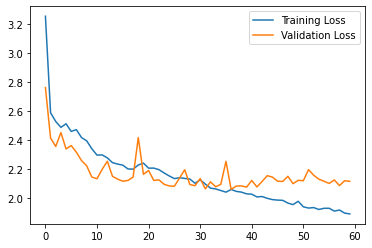

In [20]:
filepath = 'model-BiLSTM-MLP-hybrid-sm'
def make_BiLSTM():
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(Vectorizer)
    model.add(Embedding_layer)
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    # model.add(GlobalMaxPooling1D())
    # model.add(Dropout(rate=0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(rate=.1))
    model.add(Dense(1, activation='relu'))

    sgd = SGD(learning_rate=.1, decay=1e-3)

    model.compile(optimizer=sgd, loss='mean_absolute_error')
    return model

model = make_BiLSTM()
print(model.summary())
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True,
                             mode='min',
                             save_format='tf'
                             )
callbacks = [checkpoint]

history = model.fit(X_train,
            y_train,
            epochs=60,
            batch_size=100,
            validation_split = .2,
            verbose=1,
            callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [17]:
history = model.fit(X_train,
            y_train,
            epochs=60,
            batch_size=1000,
            validation_split = .2,
            verbose=1,
            callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/60
7/7 [==============================] - 3s 425ms/step - loss: 2.3480 - val_loss: 2.1326

Epoch 00001: val_loss did not improve from 2.10211
Epoch 2/60
7/7 [==============================] - 3s 420ms/step - loss: 2.2955 - val_loss: 2.1076

Epoch 00002: val_loss did not improve from 2.10211
Epoch 3/60
7/7 [==============================] - 3s 420ms/step - loss: 2.2940 - val_loss: 2.1848

Epoch 00003: val_loss did not improve from 2.10211
Epoch 4/60
7/7 [==============================] - 3s 418ms/step - loss: 2.3402 - val_loss: 2.1852

Epoch 00004: val_loss did not improve from 2.10211
Epoch 5/60
7/7 [==============================] - 3s 421ms/step - loss: 2.3181 - val_loss: 2.1113

Epoch 00005: val_loss did not improve from 2.10211
Epoch 6/60
7/7 [==============================] - 3s 420ms/step - loss: 2.2861 - val_loss: 2.1223

Epoch 00006: val_loss did not improve from 2.10211
Epoch 7/60
7/7 [==============================] - 3s 419ms/step - loss: 2.3005 - val_loss: 2.1262

E

KeyboardInterrupt: ignored

# Model Evaluation
This model takes forever to train.  While having a frozen embedding layer helps reduce the number of weights to update, you'll want to train this on something with a good CUDA GPU.  It scores a 1.7 grade level average error, quite a bit better than the FSM accuracy of 2.5.  

In [25]:
test

Grade                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [27]:
separate_sentences(df)

,Grade,Text
0,2.0,If I were president Id be responsible
1,2.0,Id look alert and run the United States like it should be run
2,2.0,Id be honest
3,2.0,Then the people would trust me
4,2.0,I would be a good president because I have faith in the people of the United States
...,...,...
9957,12.0,TIG welding is something that needs to be learned not only by textbook or paper\r
9958,12.0,but also by hands on learning
9959,12.0,"And thankfully, I have gotten that experience to weld hands on"
9960,12.0,It makes\r


In [28]:
test

Grade                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [29]:
separate_sentences(test)

,Grade,Text
0,9.0,She had finally gotten her green belt in Tae Kwando
1,9.0,It was an amazing accomplishment for Kameelah D
2,9.0,a thin African American girl standing about five feet tall
3,9.0,Only four years before she was told by a doctor that she would never walk again
4,9.0,It was quite evident that not only would she walk again but she would also run jump kick and punch
...,...,...
2153,6.0,In Haiti children are on average paid 28 cents per hour
2154,6.0,In Sri Lanka the median is 18 cents
2155,6.0,Vietnamese and Chinese children should not expect their wages to exceed 11 cents
2156,6.0,These numbers are truly tragic


In [30]:
X_test = separate_sentences(test)
y_test = X_test['Grade']
X_test[col] = prepare_text(X_test, sp)[col]
filepath = 'model-BiLSTM-MLP-hybrid-sm'
model = keras.models.load_model(filepath)
yhat = model.predict(X_test[col]).ravel()
print('MAE = ', np.sum(np.abs(y_test - yhat))/len(y_test))
print('STD of errors: ', np.abs(y_test - yhat).std())
print('mean grade prediction = ', np.mean(yhat))
print('mean grade = ', np.mean(y_test))

errors = pd.DataFrame()
errors['Text'] = X_test.Text
errors['Grade'] = y_test
errors['Predicted Grade'] = yhat
errors.sample(5)

MAE =  1.9245240049742238
STD of errors:  1.4518361595284304
mean grade prediction =  7.2302694
mean grade =  7.314179796107507


,Text,Grade,Predicted Grade
997,I reckon theyre goin fer the stairs,6.0,7.055093
694,"He was the only guest of the day, there to promote and discuss his book entitled A Million Little Pieces",12.0,8.340609
588,When its winter take buckets of snow and melt it,3.0,5.966144
1841,A hero helps,6.0,5.486671
723,call into question people’s ability to relay information truthfully and with no bias,12.0,10.991486


# Sentence Average Grade Approach

In order to create more data to train on we split samples into individual sentences while retaining the original grade label for each one.  New texts then will also be broken down into sentences, individual predictions are made on each sentence, and the model returns the mean average grade level prediction over all sentences. 

This approach was to combat previous bias in our models toward longer texts being higher grades, to create more data, and to reduce the size of input sequences.  Some of the texts are several pages long.  This also somewhat helped the class imbalance because the older students, which we had fewer of, also wrote texts with more sentences.  

Finally, it can take advantage of the 'Wisdom of the Crowds' effect to improve the accuracy on longer texts.

`predict_grade()` splits the input text into sentences, uses the input model to make predictions on each one, then returns the mean average of the sentences level predictions as the prediction for the entire text.

In [32]:
model = load_model('model-BiLSTM-MLP-hybrid-sm')
errors = test[['Text','Grade']].copy().reset_index(drop=True)
yhat = predict_grade(model, test.Text, col, sp)
errors['average_prediction'] = yhat

print('MAE of average sentence predictor is: ', np.sum(np.abs(errors['Grade'] - errors['average_prediction']))/len(errors))
errors.sample(5)

MAE of average sentence predictor is:  2.068960438913374


,Text,Grade,average_prediction
56,The Great Depression affected the people that lived through it in many ways. The things at I am going to explain are some of the things that affected the people who lived through the Great Depression. Having barely any money was one of the things that affected them. Also having less supplies affected them too. Having to take care of kids too also might have affected the people during the Great Depression. First I am going to talk about how having almost no money affected the people. It affected them because they were getting their money by working. Then their jobs were shutting down so their amount of money was shrinking and shrinking. They would do neighborhood favors and jobs but the amount of money they would get was five dollors. They also had to pay a bill for electricity every month. They had to pay for gas if you had a car and their house. That is why having almost no money affected them a lot. Another reason the Great Depression affected the people was they were having less of the supplies they had. Like some of the people stopped delivery for several things such as milk and ice. They were also using less electricity and selling their cars. Those are some of supplies they had a shortage or had to not use as much. Also if they had kids they would need to do extra work and be able to care for them. They also had to pay more money if they had kids because they have to feed them too. They also had to take care of them. The parents have to care for them. If they are sick they can not just leave them at home they have to take care of them. They also might worry about them. If you had kids during the Great Depression not only would you worry about your kids and family. That is why if you had kids during the Great Depression it might be more difficult. Now you can see how living through the Great Depression was very difficult and affected many people who lived through it. It affected people in many ways like having no money or having a very little amount of it. Also if you had kids it might have been a little more difficult. They also had to live with less supplies. That is why I think the Great Depression affected the people who lived through it.,6.0,6.396696
18,Its too bad that Mr. Griff is closing the shop Queen thought to herself. Queen and the three dogs had been pets of Mr. Griff the owner but now the shop was going out of business and Mr. Griff put all the furniture outside his shop so people could look at it. Queen had to hold a meeting with the dogs. They loved the shop but they would probably have to go to the pound because Mr. Griff wouldnt be able to feed them with what little money he had. Queen meowed a couple of times and the dogs came bounding over. First Charlie then Skip and then Spot. Queen climbed up to the top of the velvet chair and got right down to the point. You guys are going to have to leave here or go to the pound. What do you want to do? We wouldnt go to the pound for anything they chorused. So I guess youre leaving Queen said. Queen was trying to hold tears back. She loved the dogs but she wouldnt be able to come with them. She had a bad leg and whenever she tried to run pain would shoot up her leg like a lightning bolt electrocuting someone. Queen would have to go to the pound or be a street catâ€”an idea she disliked. Do you boys have all your toys with you? Yes we do. Are you sure you will be OK without me? We think so. Queen followed the boys into the shop so she could hear their barks of goodbye to Mr. Griff. But Mr. Griff was talking to a man. After what seemed like an eternity the man left with a grin on his face. Mr. Griff also had a grin on his face. My wonderful pets we will be able to stay in the upstairs apartment because that wonderful man bought the shop from us but he is letting us stay upstairs still! The dogs jumped for joy and even though she couldnt jump Queen started to purr.,5.0,5.704593
27,When spring is in the air Most of the flowers care. A

In [ ]:
X_train

In [ ]:
test[col]

The accuracy jumped from 1.8 grade levels average error to 1.4.  In other words, the longer the writing sample, the more accurate the model should be, at least up to a point.

Another note here is that while the model takes a long time to load, being almost a 1GB in size, the predictions aren't too slow.

# Conclusion
With a top accuracy of 1.4 grade levels average error, this model is probably not very useful to a teacher. There are many aspects that go into writing development and the small sample size of our data doesn't give enough.  While dividing texts by sentences raises our sample size from ~300 to ~10,000, there are still only 300 individual writers represented.  The component sentences in a document are going to be highly correlated to the writer and therefor offer less diverse information to the model than if all 10,000 were from independent sources.  

~300 is just not enough student writers to find the trends in the noise.  A dataset of 10,000 writing samples from young writers, labeled with their current grade of study, might be enough to return some very interesting insights and much more accurate predictions.  Ideally the writing samples would be selected as representing grade appropriate standards according to the CCSS.  If an accurate predictor could be created that would return the Common Core Standards aligned grade level of a writing, based on writing mechanics.

Our baseline model, simply the median of the training set predicted for every text, had an average accuracy of 2.6 grade levels on the validation set.  Traditional machine learning models, linear regression, random forest, and XGBoost improved on that a little by encoding the texts into TF-IDF vectors and fitting on them.  

We then tried vectorizing the texts using pre-trained word embedding vectors from the SpaCy large web collected word embedding dictionary.  We used a TextVectorization layer to first encode the words in the text into integers, which the model then used to look up the embeddings in the embedding layer.  This added a dimension to our data before it was passed into a bidirectional Long-Short Term Memory recurrent neural network layer.  The output sequence of that LSTM is flattened and passed through 10 layers of ever shrinking dense layers interspersed with dropout layers for regularization.

The output is a regression, not a classification.  It would be simple to make it a classification with rounding, though.  This is essentially what a sigmoid activation on the final layer would do anyway.

The model scores significantly better than both the median predictor and any of the shallow models.  While an accuracy of rough one and a half grade levels may not be good enough for use by teachers, it is proof that writing level CAN be predicted, at least to some degree.  

# Future Study
I recommend more study go into modeling writing development.  The greatest need, from what I could find, is in the collection and anonymization of labeled writing samples from K-12 students.  With a greater library of labeled samples I hypothesize that the model can achieve a precision within one grade level.

There are also many more modeling options that can be explored.  I've seen some architectures with convolutional layers.  

There are also many more opportunities for text preparation.  NLP is a complex art and tools abound.